In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re

from pythainlp import word_tokenize, Tokenizer
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords
from pythainlp.tag import pos_tag
from pythainlp.summarize import summarize
from pythainlp.spell import correct

# from pythainlp.sentiment import sentiment
from pythainlp.util import rank
stopwords = list(thai_stopwords())

In [350]:
class DataProcessor:
    def __init__(self):
        self.data = None
        
    def load_data(self, file_path):
        self.data = pd.read_excel(file_path)
        
    @staticmethod
    def _literal_eval(s):
        try:
            return ast.literal_eval(s)
        except ValueError:
            return None 
        
    def process_data(self):
        # Convert string representation of dictionary to actual dictionary
        self.data['Author'] = self.data['Author'].apply(self._literal_eval)
        
        # Extract 'id', 'name', and 'url' values into separate columns
        self.data['name'] = self.data['Author'].apply(lambda x: x.get('name', '') if isinstance(x, dict) else x)
        
        # Select and rename columns
        self.data = self.data[['name', 'query_name', 'Created_time', 'Content_type', 'Post_text', 'sentiment', 'Interactions', 'Comments', 'shares']]
        self.data = self.data.rename(columns={'query_name': 'page', 'Created_time': 'time', 'Post_text': 'text', 'Content_type': 'type',
                                              'Interactions': 'interactions', 'Comments': 'comments'})
        
    def tokenize_text(self):
        def text_preprocessing(text):

            url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
            user_pattern = r"@[^\s]+"
            entity_pattern = r"&.*;"
            emoji_pattern = re.compile(
                "["
                "\U0001F600-\U0001F64F"  # emoticons
                "\U0001F300-\U0001F5FF"  # symbols & pictographs
                "\U0001F680-\U0001F6FF"  # transport & map symbols
                "\U0001F700-\U0001F77F"  # alchemical symbols
                "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                "\U0001FA00-\U0001FA6F"  # Chess Symbols
                "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                "\U00002702-\U000027B0"  # Dingbats
                "\U000024C2-\U0001F251"  
                "\U0001F600-\U0001F64F"  # emoticons
                "\U0001F300-\U0001F5FF"  # symbols & pictographs
                "\U0001F680-\U0001F6FF"  # transport & map symbols
                "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                "]+", 
                flags=re.UNICODE
            )
            symbols = "'{}()[].,:;+-*/&|<>=~'"

        
            # Remove URLs
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

            # Remove HTML tags
            text = re.sub(r'<.*?>', '', text)

            # Remove special characters and numbers
            text = re.sub(r'[a-zA-Z]', '', text)
            text = re.sub(r'\d', '', text)
            
            text = text.lower()
            text = text.replace(symbols, "")
            text = re.sub(url_pattern, " ", text)
            text = re.sub(user_pattern, " ", text)
            text = re.sub(entity_pattern, " ", text)
            text = re.sub(emoji_pattern, " ", text)

            return text
    
        def posTagging(token):
            # provide POS tag for lemmatization to yield better result
            word_tag_tuples = pos_tag(token)
            tag_dict = {"NOUN": "n", "VERB": "v", "ADJ": "a", "ADV": "r"}
            final_tokens = []
            for word, tag in word_tag_tuples:
                if len(word) > 1 and word not in stopwords and word in thai_words():
                    if tag in tag_dict:
                        final_tokens.append(word, tag_dict[tag])
                    else:
                        final_tokens.append(word)
                        
            return final_tokens
                        
        # Remove symbols from the 'text' column
        self.data['cleaned_text'] = self.data['text'].apply(text_preprocessing)
 
        # Tokenize 'cleaned_text' column and store the result in a new column 'tokens'
        # self.data['cleaned_text'] = self.data['text'].apply(summarize)
        self.data['text_tokens'] = self.data['cleaned_text'].apply(lambda text : word_tokenize(text, engine='deepcut'))
        self.data['text_tokens'] = self.data['text_tokens'].apply(lambda token: [word for word in token if word not in stopwords])
        self.data['text_tokens'] = self.data['text_tokens'].apply(lambda token: posTagging(token))
        # self.data['text_tokens'] = self.data['text_tokens'].apply(lambda token: ' '.join(token))
        

# Usage
processor = DataProcessor()
processor.load_data("sample_data.xlsx")
processor.process_data()
processor.tokenize_text()
df = processor.data
df.head()

1/1 [==============================] - 0s 63ms/step


,name,page,time,type,text,sentiment,interactions,comments,shares,cleaned_text,text_tokens
0,Rita Khurana Insari,Life_Motorcycle,2022-11-19 09:28:28,comment,ซื้อมอเตอร์ไซค์HondaClickตัวใหม่ที่นิยมพานิชสา...,neg,0,0,0,ซื้อมอเตอร์ไซค์ตัวใหม่ที่นิยมพานิชสาขาเชียงใหม...,"[ซื้อ, มอเตอร์ไซค์, ตัว, นิยม, ป่าน, ทะเบียน, ..."
1,SCB Thailand,Business_Banking,2022-11-13 05:14:41,comment,อย่างไรแนะนำท่านตรวจสอบรายการเพิ่มเติมอีกครั้ง...,pos,0,0,0,อย่างไรแนะนำท่านตรวจสอบรายการเพิ่มเติมอีกครั้ง...,"[แนะนำ, ท่าน, ตรวจสอบ, รายการ, เช้า, ธนาคาร, ต..."
2,Panu Bee Rot,Business_Banking,2022-11-01 09:10:59,comment,แสกนหน้าไม่ผ่านทำไมแอฟของภาครัฐชอบให้แสกนหน้าจ...,neg,1,1,0,แสกนหน้าไม่ผ่านทำไมแอฟของภาครัฐชอบให้แสกนหน้าจ...,"[รัฐ, ชอบ, เป๋า, ตัง, ธนาคาร]"
3,Chattip Rueangchan,Thailand_Environment,2022-11-26 11:43:18,comment,ร่วมกิจกรรมค่ะBCGModelแนวคิดหลักของAPEC2022คือ...,pos,1,1,0,ร่วมกิจกรรมค่ะแนวคิดหลักของคือเศรษฐกิจชีวภาพเศ...,"[กิจกรรม, แนว, หลัก, เศรษฐกิจ, ชีวภาพ, เศรษฐกิ..."
4,Kirino Yome,AMPT,2022-11-03 01:24:13,comment,เน็ตคุณทำให้มันดีๆหน่อยครับเดี๋ยวก็หลุดเดี๋ยวก...,neg,1,1,0,เน็ตคุณทำให้มันดีๆหน่อยครับเดี๋ยวก็หลุดเดี๋ยวก...,"[เน็ต, ทำ, ดี, เดี๋ยว, หลุด, เดี๋ยว, หัว, ร้อน..."


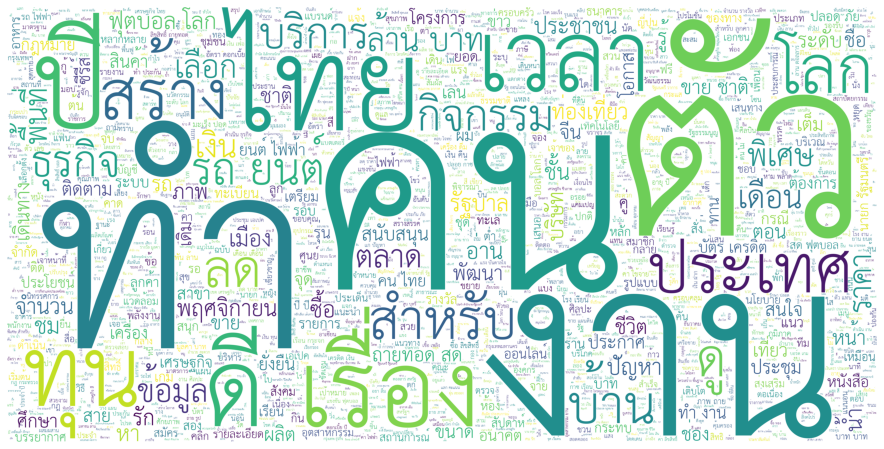

In [353]:
words = " ".join(text for text in df['text_tokens'])
reg = r"[ก-๙a-zA-Z']+"
fp = 'thsarabunnew-webfont.ttf'
wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words=2000, height = 2000, font_path=fp, width=4000, regexp=reg).generate(words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

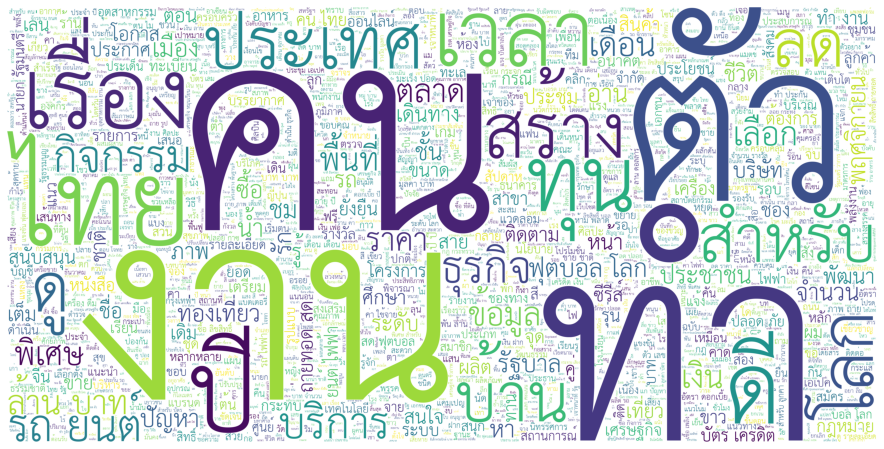

In [354]:
words = " ".join(text for text in df[df.sentiment=='pos']['text_tokens'])
reg = r"[ก-๙a-zA-Z']+"
fp = 'thsarabunnew-webfont.ttf'
wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words=2000, height = 2000, font_path=fp, width=4000, regexp=reg).generate(words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

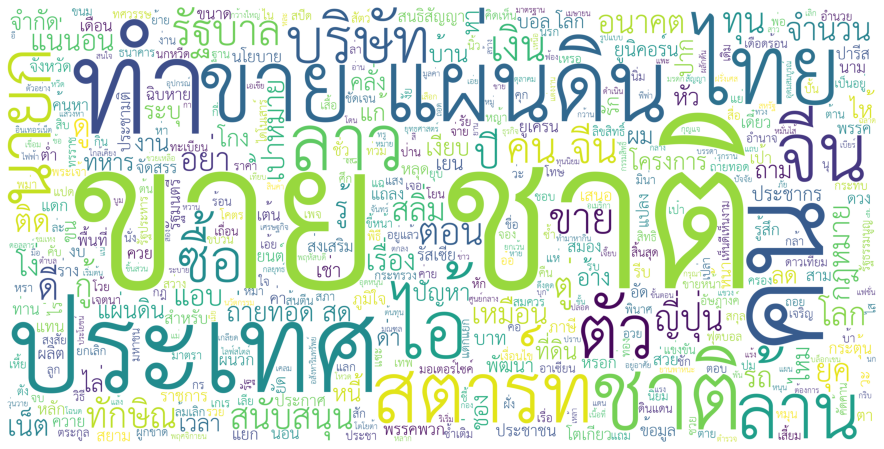

In [355]:
words = " ".join(text for text in df[df.sentiment=='neg']['text_tokens'])
reg = r"[ก-๙a-zA-Z']+"
fp = 'thsarabunnew-webfont.ttf'
wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words=2000, height = 2000, font_path=fp, width=4000, regexp=reg).generate(words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

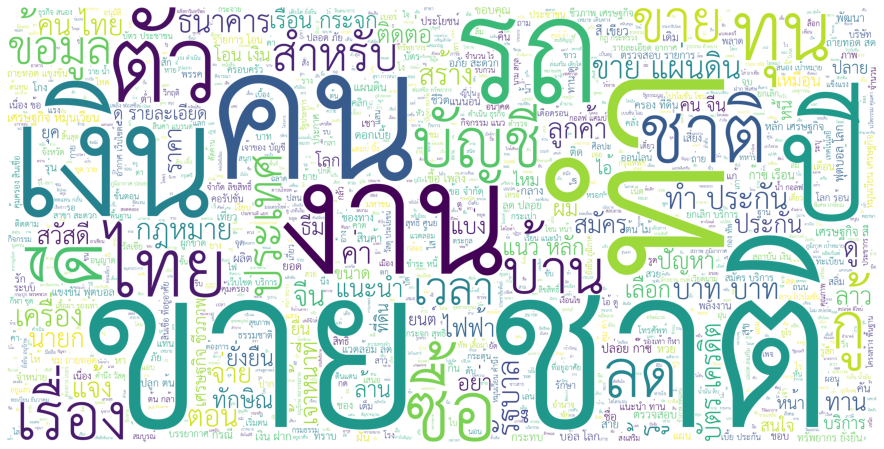

In [356]:
words = " ".join(text for text in df[df.type=='comment']['text_tokens'])
reg = r"[ก-๙a-zA-Z']+"
fp = 'thsarabunnew-webfont.ttf'
wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words=2000, height = 2000, font_path=fp, width=4000, regexp=reg).generate(words)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [359]:
df = df.replace('neg', 'Negative').replace('pos', 'Positive')
df.to_excel('cleaned_sample_v3.xlsx')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10452\1964708541.py:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  df.to_excel('cleaned_sample_v3.xlsx')


In [339]:
df = df.replace('neg', 'Negative').replace('pos', 'Positive')

In [326]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

dff = df[df.type=='comment']
X = dff[['text_tokens']]
y = dff['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

cvec = TfidfVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train['text_tokens'])
cvec.vocabulary_

{'กระตุ้น': 14,
 'เศรษฐกิจ': 1195,
 'กำลังซื้อ': 72,
 'คน': 134,
 'ภายในประเทศ': 641,
 'ทำ': 424,
 'รายได้': 767,
 'งาน': 225,
 'ซัพพลาย': 302,
 'สินค้า': 915,
 'ดีมานด์': 329,
 'ผลกระทบ': 567,
 'ข้อ': 127,
 'ขาย': 113,
 'ผู้ค้า': 577,
 'รายย่อย': 765,
 'อุตสาหกรรม': 1048,
 'ขนาดเล็ก': 98,
 'ขนาดย่อม': 97,
 'ขนาด': 96,
 'กลาง': 30,
 'ขนาดใหญ่': 99,
 'ทุน': 440,
 'เงินทุน': 1092,
 'ระยะสั้น': 745,
 'ปานกลาง': 556,
 'ระยะยาว': 744,
 'ลด': 798,
 'ต้นทุน': 389,
 'การผลิต': 53,
 'ที่สูง': 436,
 'หา': 984,
 'มาตรการ': 670,
 'ส่งเสริม': 935,
 'เบื้องหลัง': 1150,
 'ความล้มเหลว': 174,
 'ทางเศรษฐกิจ': 422,
 'แทรกแซง': 1261,
 'ขัดขวาง': 110,
 'ทางการเมือง': 421,
 'อำมาตย์': 1036,
 'นายทุน': 470,
 'คุม': 208,
 'อำนาจ': 1035,
 'ผูกขาด': 574,
 'โดยเฉพาะ': 1318,
 'ตระกูล': 343,
 'การเอารัดเอาเปรียบ': 67,
 'สังคม': 893,
 'การลงทุน': 56,
 'ก่อ': 88,
 'จัดซื้อ': 238,
 'อาวุธ': 1030,
 'ยุ': 710,
 'โป': 1326,
 'กองทัพ': 40,
 'สร้าง': 878,
 'วิกฤติ': 837,
 'ประเทศ': 533,
 'การปฏิวัติ': 52,
 'การปฏิรูป': 51

In [327]:
# df = pd.read_excel('cleaned_sample.xlsx', index_col=0)
# df = df.dropna(subset='text_tokens')

In [328]:
# from collections import Counter
# from nltk.util import ngrams
# from pythainlp import word_tokenize

# # Tokenization using pythainlp
# # tokens = word_tokenize(text, keep_whitespace=False)
# words = " ".join(text for text in df[df.type=='comment']['text_tokens'])
# tokens = words.split(" ")

# # Extract bigrams (2-grams)
# bigrams = list(ngrams(tokens, 2))

# # Count the bigrams
# bigram_counts = Counter(bigrams)
# # Convert to DataFrame
# dff = pd.DataFrame([( ' '.join(k), v) for k, v in bigram_counts.items()], columns=['text', 'count'])
# dff = dff.sort_values('count', ascending=False).reset_index(drop=True)
# print(dff)


In [335]:
train_bow = cvec.transform(X_train['text_tokens'])
pd.DataFrame(train_bow.toarray(), columns=cvec.get_feature_names(), index=X_train['text_tokens']).max()

กก             0.819155
กฎกระทรวง      0.197316
กฎหมาย         0.501108
กฎหมายมหาชน    0.209375
กด             0.213810
                 ...   
ไห้            0.341390
ไอเทม          0.248733
ไอ้            0.856298
ไอ้บ้า         0.363299
ไฮโดรเจน       0.262846
Length: 1396, dtype: float64

In [336]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bow, y_train)

LogisticRegression()

In [338]:
from sklearn.metrics import confusion_matrix,classification_report
test_bow = cvec.transform(X_test['text_tokens'])
test_predictions = lr.predict(test_bow)
print(classification_report(test_predictions, y_test))

              precision    recall  f1-score   support

         neg       0.60      0.79      0.68        19
         pos       0.91      0.80      0.85        51

    accuracy                           0.80        70
   macro avg       0.76      0.80      0.77        70
weighted avg       0.83      0.80      0.81        70



classification

In [277]:
df.page.value_counts()

page
Culture_TV and Entertainment (Series)    162
Thailand_Law_ต่างชาติถือครองที่ดิน        91
Culture_Art and Design                    89
ลิขสิทธิ์บอลโลก                           67
Business_Banking                          60
Thailand_Environment                      55
AMPT                                      45
Life_Travel (Thai)                        42
What if_EV Car                            42
Thailand_constitution                     25
Life_Car                                  21
Thailand_Infra_คมนาคม                     20
Business_Insurance                        18
COKE vs PEPSI                             15
Life_Travel (Foreign)                     15
Culture_Book                              11
CP กับ Worldcup                           11
Thailand_Corruption                       11
สถานีชาร์จรถยนต์ไฟฟ้า                      8
Thailand_Envi_สาธารณสุข                    7
Move1                                      6
Business_Economy (อุตสาหกรรม)              5
ประกั

In [144]:
# Travel & Lifestyle:

# Life_Motorcycle
# Life_Travel (Thai)
# Life_Travel (Foreign)
# Life_Car
# Life_EV Car

# Business & Economy:
# Business_Banking
# Business_Insurance
# Business_Economy (อุตสาหกรรม)
# Business_Crypto
# Business_WorkLife
# ฺีBusiness_Gold Investment
# CP กับ Worldcup

# Culture & Entertainment:
# Culture_TV and Entertainment (Series)
# Culture_Art and Design
# Culture_Book

# Environment & Infrastructure:
# Thailand_Environment
# Thailand_Envi_สาธารณสุข
# Thailand_Infra_คมนาคม

# Law & Politics:
# Thailand_Law_ต่างชาติถือครองที่ดิน
# Thailand_constitution
# Thailand_Corruption

# Miscellaneous:
# AMPT
# AMPP
# UTNP
# Move1
# Move2
# COKE vs PEPSI
# Christmas Gift_2022
# ลิขสิทธิ์บอลโลก
# สถานีชาร์จรถยนต์ไฟฟ้า
# ประกันรถยนต์ไฟฟ้า
# What if_EV Car

Text(0.5, 0, 'Date')

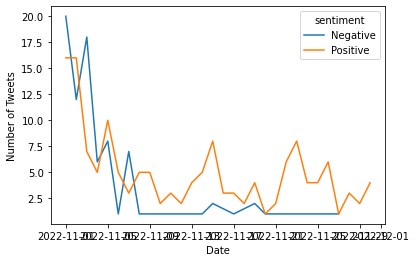

In [247]:
dff = df.groupby([df.time.dt.date, 'sentiment']).size().reset_index(name='count')
dff['time'] = pd.to_datetime(dff['time'])
import seaborn as sns
sns.lineplot(data=dff, x='time', y='count', hue='sentiment', legend=True)
plt.ylabel('Number of Tweets')
plt.xlabel('Date')

In [242]:
dff.time.dtypes

dtype('O')